<a href="https://colab.research.google.com/github/CecinestpasJonatan/MachineaLearningIntroNotebook/blob/main/MachineLearningIntro_2_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lets try a even more current example:

A common machine learning task is to identify written symbols in order to transcribe images. A common dataset to use to illustrate this is called the MNIST dataset, which consists of 70000 handwritten images of numbers. We will now see if we can use deep learning to identify these handwritten numbers. An example of data points from this dataset i shown below. First download the data by runing the first cell.

In [ ]:
#@title Code
!pip install torchview --quiet
!pip install torchviz --quiet
!pip install graphviz --quiet

!pip install umap-learn

import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

batch_size_train = 64
batch_size_test = batch_size_train

train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                               (0.1307,), (0.3081,))
                               ])), batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                                          transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(
                                          (0.1307,), (0.3081,))
                                          ])),batch_size=batch_size_test, shuffle=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 856.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.3 MB/s eta 0:00:00
Failed to download (trying next):
HTTP Error 

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.8MB/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.50MB/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.07MB/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



Then plot some examples by running the next cell.

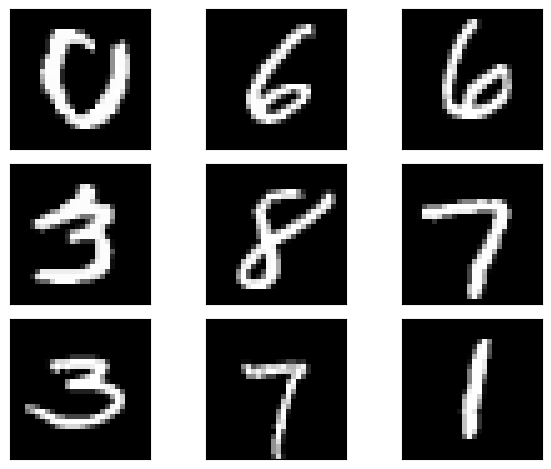

In [ ]:
#@title Code
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Now, lets construct a neural network to train how classify these handwritten digits. First we need to construct a network which we want to train. Lets build a network with 2 layers of 64 neurons each. To make our data possible to feed into the network, we need to "flatten" the images into 1D arrays, which can then be used as input for the network. Then, in order to make a prediction, we add an output layer with 10 different neurons, which will represent each of the possible digits. The idea is to make the output neurons represent the likelihood of the input image containing each specific digit.

In [ ]:
#@title Code
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, 10)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return F.log_softmax(x)

learning_rate = 0.01
momentum = 0.5
log_interval = 100
n_epochs = 10

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))



Lets visualize the network to make it somewhat more understandable.

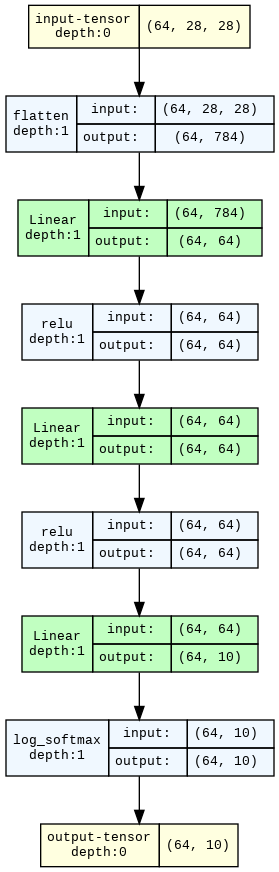

In [ ]:
#@title Code
from torchviz import make_dot
import torchvision
from torchview import draw_graph
import graphviz

graphviz.set_jupyter_format('png')
model_graph = draw_graph(network, input_size=(64, 28, 28), expand_nested=True)
model_graph.visual_graph



First we have a high level view of the network, shown above. Here we see the input layer, consiting of 64 images being input at once, each image consisting of 28 by 28 pixels. The after the input layer we have the flatten layer, which turns the 2-dimensinal image into a 1-dimensional array. After that we have the first neuron layer, consisting of 64 neurons, each of which are connected to each pixel in the input image. After that there is an activation layer, which sums all inputs to each neuron and calculates what value to pass forward to the next layer. After that there is another layer with 64 neurons, each connected to each neuron in the previous layer, followed by another activation layer.

At the end, we have a layer consisting of 10 neurons. These represent the each digit which we want to predict the input image as belonging to. Each of these neurons takes a weighted sum of the output from the neurons in the previous layer, same as before, but this time the activation function used is called a SoftMax function. This functions normalizes the output of all the neurons in the output layer, generating a probability function. This function is then used to determine which what probability as certain data points belongs to a certain digits class, using a loss function called Categorical Crossentropy.


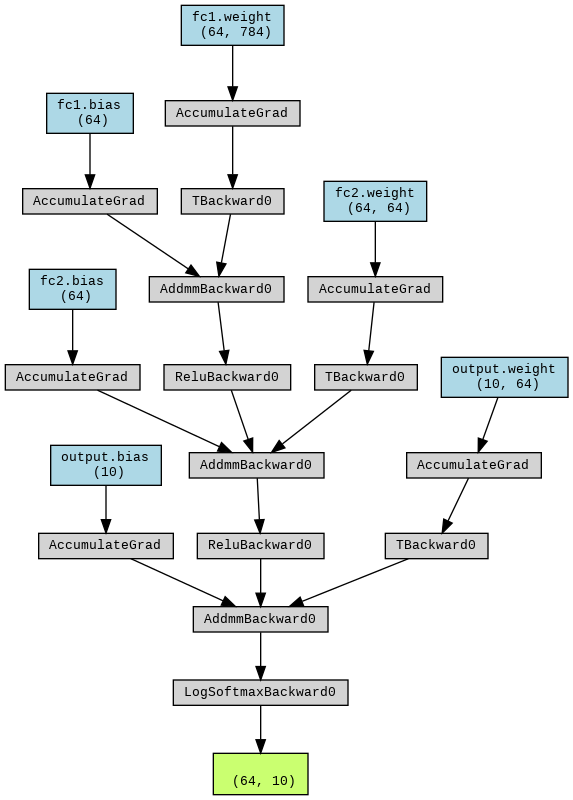

In [ ]:
#@title Code
batch = next(iter(train_loader))
yhat = network(batch[0])
make_dot(yhat, params=dict(list(network.named_parameters())))

Here is another view of the network, which is what the computer actually 'sees'. This is the computational graph which is defined in out network architecture above, which includes all computations relating to training and predicting. While not essential to understand for doing some basic training, it is important for debugging some issues which might occury when building a new network.

So, no it's time to actually train our network. The network is trained by predticting the class of each image in the training dataset, 64 at once, and then using the detected error to backpropagate and update the weights of each layer. After each iteration, called an "epoch", the model is tested on a test dataset, which is not used for training. The number of epoch for which the network is trained here are 10 epochs.

In [ ]:
#@title Code
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310398
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.207395
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.494945
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.396028
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.342963
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.225908
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.360676
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.224776
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.414245
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.264261

Test set: Avg. loss: 0.2899, Accuracy: 9141/10000 (91.4100%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.126438
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.340502
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.132840
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.454288
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.130875
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.336722
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.262226
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.063442
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.187181

Around 97% accuracy on the test data, that's pretty good! We can have a look at a graph showing the loss as the network is being trained on the data.

Text(0, 0.5, 'negative log likelihood loss')

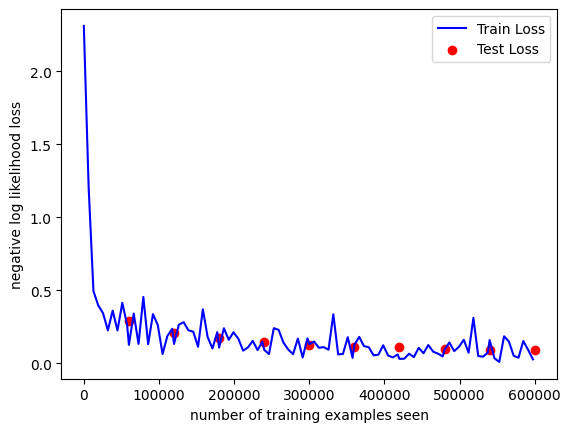

In [ ]:
#@title Code
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter[1:], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

Now, the question is of course, will the same hold try for other numbers? Lets do a test, by changing the data just a tiny bit, will the accuracy remain?

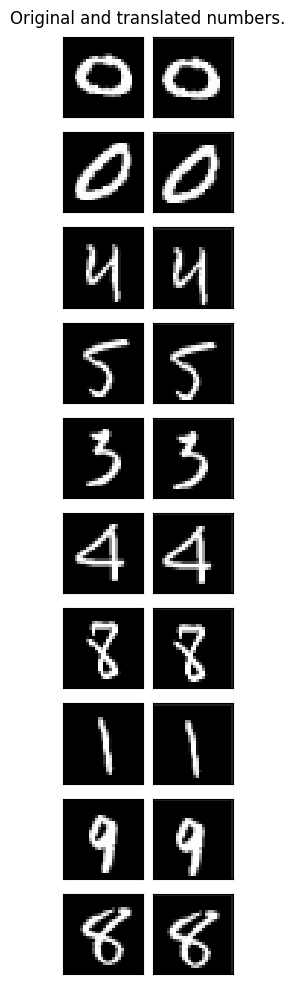

In [ ]:
#@title Code
for data, target in test_loader:
  perturbed_numbers = torchvision.transforms.RandomAffine(0, translate=(0.075, 0.075), interpolation=torchvision.transforms.InterpolationMode.BILINEAR).forward(data)
  fig = plt.figure(figsize=(2, 10))
  for i in range(10):
    plt.subplot(10, 2, i*2+1)
    plt.imshow(data[i, 0, :, :], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(10, 2, i*2+2)
    plt.imshow(perturbed_numbers[i, 0, :, :], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
  break
plt.suptitle("Original and translated numbers.")
plt.tight_layout()

As we can see, these translations are very small, that shouldn't make a difference when it comes to accuracy, right?

In [ ]:
#@title Code
def test_perturbed():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(torchvision.transforms.RandomAffine(0, translate=(0.075, 0.075), interpolation=torchvision.transforms.InterpolationMode.BILINEAR).forward(data))
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

test_perturbed()


Test set: Avg. loss: 0.7626, Accuracy: 7964/10000 (80%)



Oh no, much worse accuray, what happened here? By randomly translating the image by a couple of percent the accuracy dropped significantly. This is due to the network architecture, where we connect each pixel to each neuron, which means that the network will fail to identify images where the pixels are changed by translation or rotation compared to the training data, resulting in new input neurons being activated. This means that a network trained on data where specific pixels are mapped to specific input neurons will give vastly different results. Evidently we need a new appoach.

In [ ]:
#@title Code
class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding='same')
        self.conv3 = nn.Conv2d(20, 30, kernel_size=5, padding='same')

        self.conv2_drop = nn.Dropout2d()
        self.conv3_drop = nn.Dropout2d()

        #self.fc1 = nn.Linear(980, 50)
        self.fc1 = nn.Linear(270, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x_skip = x
        x = F.relu(F.max_pool2d(F.relu(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(F.relu(self.conv2(x))), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(F.relu(self.conv3(x))), 2))

        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))

        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x)

networkCNN = NetCNN()
optimizerCNN = optim.SGD(networkCNN.parameters(), lr=learning_rate, momentum=momentum)

def trainCNN(epoch):
  networkCNN.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizerCNN.zero_grad()
    output = networkCNN(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizerCNN.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

def testCNN():
  networkCNN.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = networkCNN(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

for epoch in range(1, n_epochs + 1):
  trainCNN(epoch)
  testCNN()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310370
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.267028
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.176950
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.628517
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.990762
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.088523
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.848335
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.757198
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.100626
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.603017

Test set: Avg. loss: 0.2426, Accuracy: 9311/10000 (93.1100%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.645681
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.426340
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.503730
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.392775
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.307339
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.419272
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.292651
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.300847
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.443539

So how good is this new network at classifing out slightly pertubed images?

In [ ]:
#@title Code
def test_perturbed():
  networkCNN.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = networkCNN(torchvision.transforms.RandomAffine(0, translate=(0.075, 0.075), interpolation=torchvision.transforms.InterpolationMode.BILINEAR).forward(data))
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

test_perturbed()


Test set: Avg. loss: 0.1840, Accuracy: 9470/10000 (95%)



Much better! So what is the differnece between these two network? In the first network we used the raw pixels as input data for the network to train on. The relation between different shapes and the digit labels is left up to the network, and any pixel is allowd to be combined with any other pixel when performing the classification task. However, the pixels of the shapes for each digit are not actually independent of each other, in reality each digit is made up of local shapes and geometries which are essential to identify when classifying these digits. It turns out a fully connected neural network has a hard time identifying these shapes, as there is no restriction on how pixels and neurons are connected.

In the second network we use a different approach. Instead of allowing all types of connections we restrict the possible connections by specifying that, locally, each pixel can only be connected to its neighboring pixels in the hidden layers. This introduces an inductive bias which forces the network to consider local geometries over lager spanning geometries. This type of network layer is call a convolutional neural network, or CNN, and is widely (an understatement) used for all types of image classification.

A CNN layer consists of one or more 'filters'. Each filter consists of a N-by-M grid of weights and are applied to the whole image, or convolved, resulting in each N-by-M section of the image being piecewise multiplied with the weights, resulting in an activation which depends on how well the shapes present in image patch matches the filter's weights. It is usually the case that an image contains numerous shapes of interest, which is why multiple filters are applied to the image.

Now, the question is, how should we design these filters? The answer is that we don't, instead we use gradient descent to train these filters using an end-to-end neural network. That is, the features and shapes for each filter is learned from the data set. The most common way to construct a convolution neural network is to use a number of layers of CNN at the beginning of the network, after which the output of these layers are connected to a fully connected network which is then used for the final classification. This enables the classification error to be backpropagated through the network to tune the filters and provide a more robust and generalizable model.

![cnn_example](https://miro.medium.com/v2/resize:fit:1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

There are some observations that can be made regarding this architecture. If we use N-by-M sized filters, lets say a 3-by-3 filter, does that mean that we only can identify features that are a maximum of 3-by-3 pixels wide? The answer lies in the fact that we usually stack multiple layers of CNNs, which introduces something called a receptive field.

![receptive_field](https://theaisummer.com/static/490be17ee7f19b78003c3fdf5a6bbafc/83b75/receptive-field-in-convolutional-networks.png)

That means that each pixel in the later layers are connected through the convultional operation to a large number of pixels in the earlier layers, enabling the network to identify larger features than what is possible using just one layer. Using multiple layers also introduces a hierchical features, where the larger features are made up of a number of smaller identified features. One thing to note is that after the first couple of layers we start to lose interperability of what the features actually mean, while early layers can be applied to an image to see what the network acutally "sees" (shapes of different kinds), the layer layers consists of stacked layers of feature abstraction, meaning that what features each filter actually indentifies as valueable becomes a lot harder to interpret.

Some additional note on the CNN architecture: it is common practice to downsample the output of each filter after one or more layers of CNNs, either by averaing the output for a certain patch of pixels, or by selecting the maximum output of these filters. This is done to introduce invariance in the network, where each filter will be affected less by small changes in input. It is also done to lessen the amount of compute needed to train the networks. It is also common to increase the number of channels as the output of each layer becomes smaller, encouraing a more efficient and hierchical representation of the data. In the end what is actually connected to the fully connected layers of the neural network can be as little as a single neuron for each collection of feautures.

So, what does the network see? Using some extra code, we can take a look at the activations of the two layers on our simple CNN.



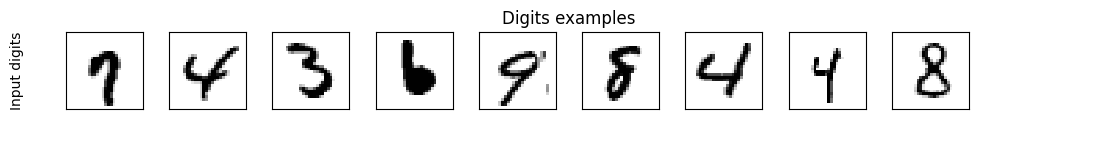

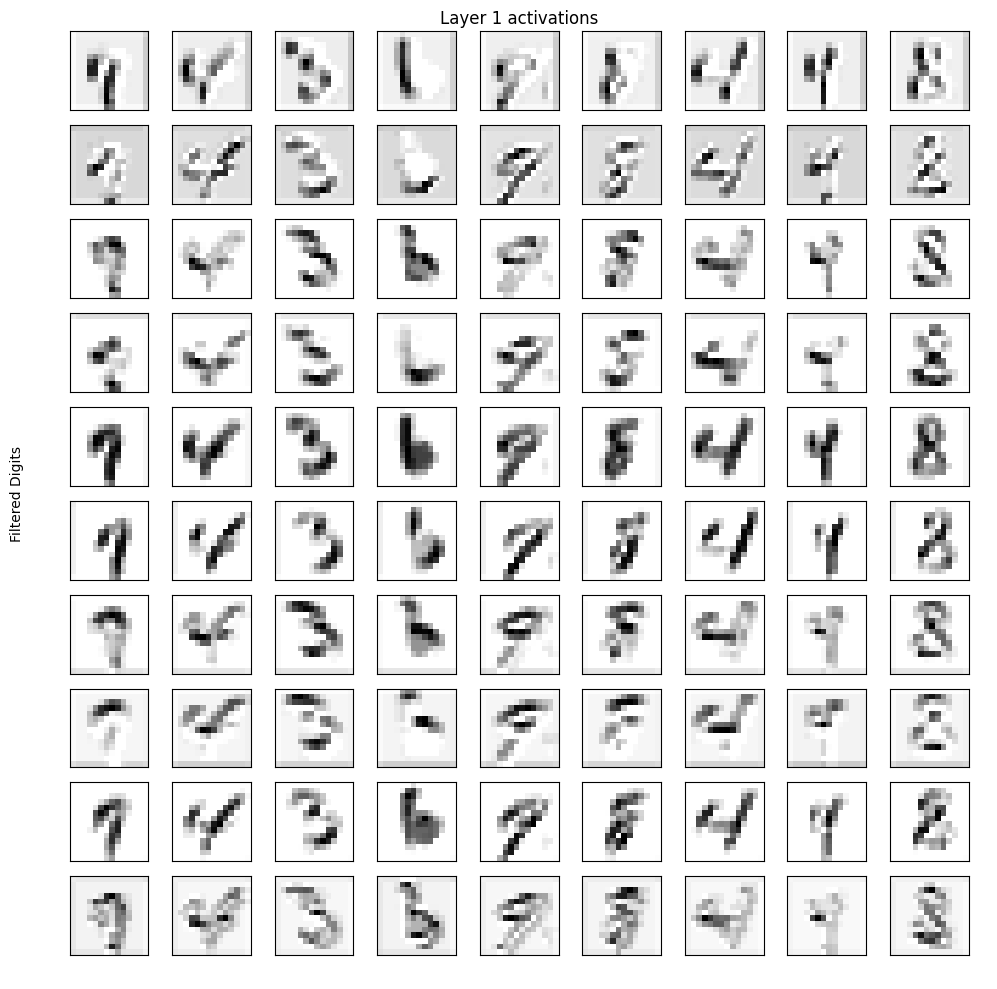

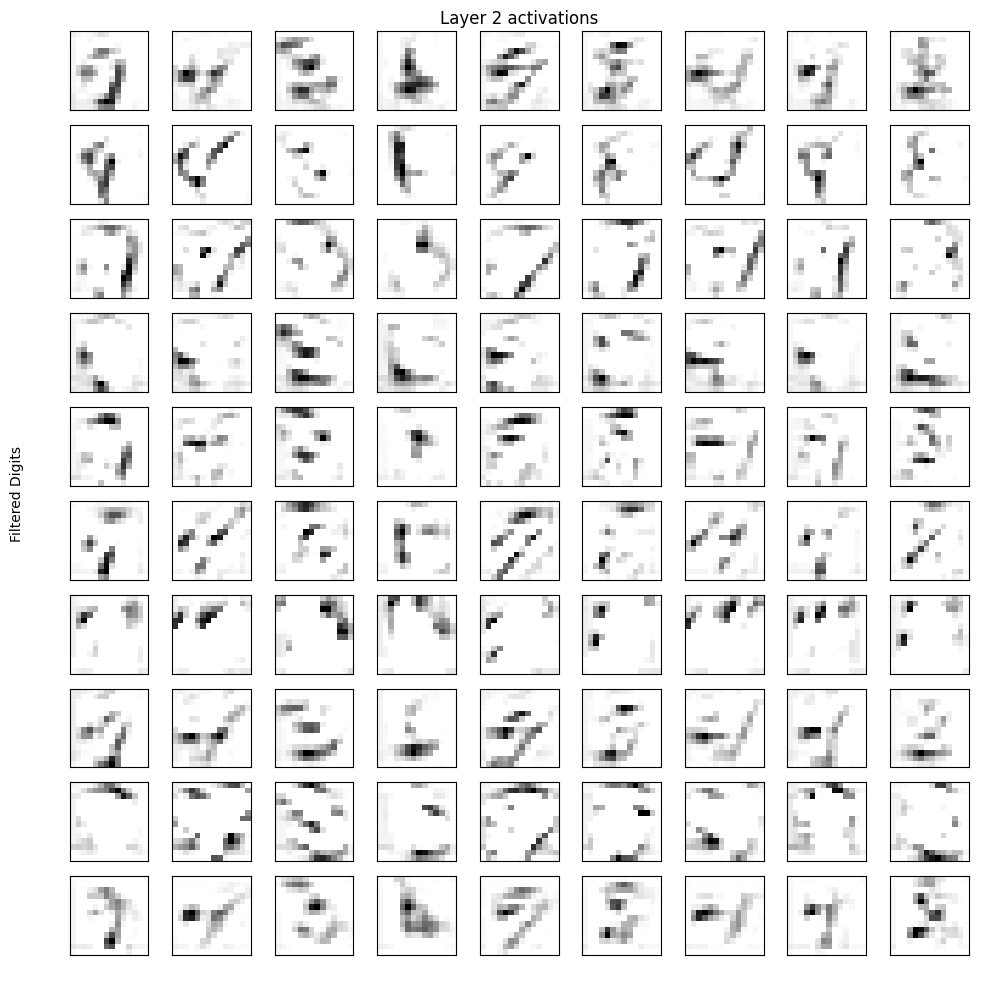

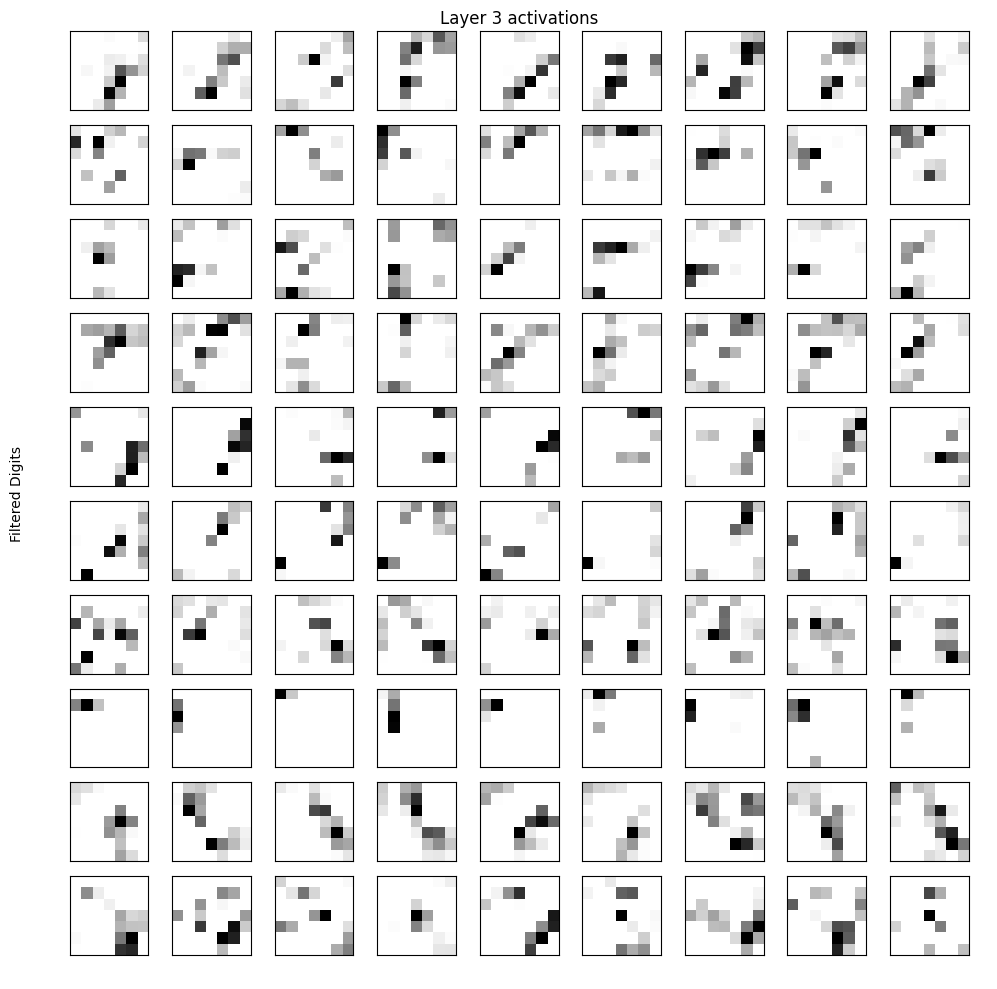

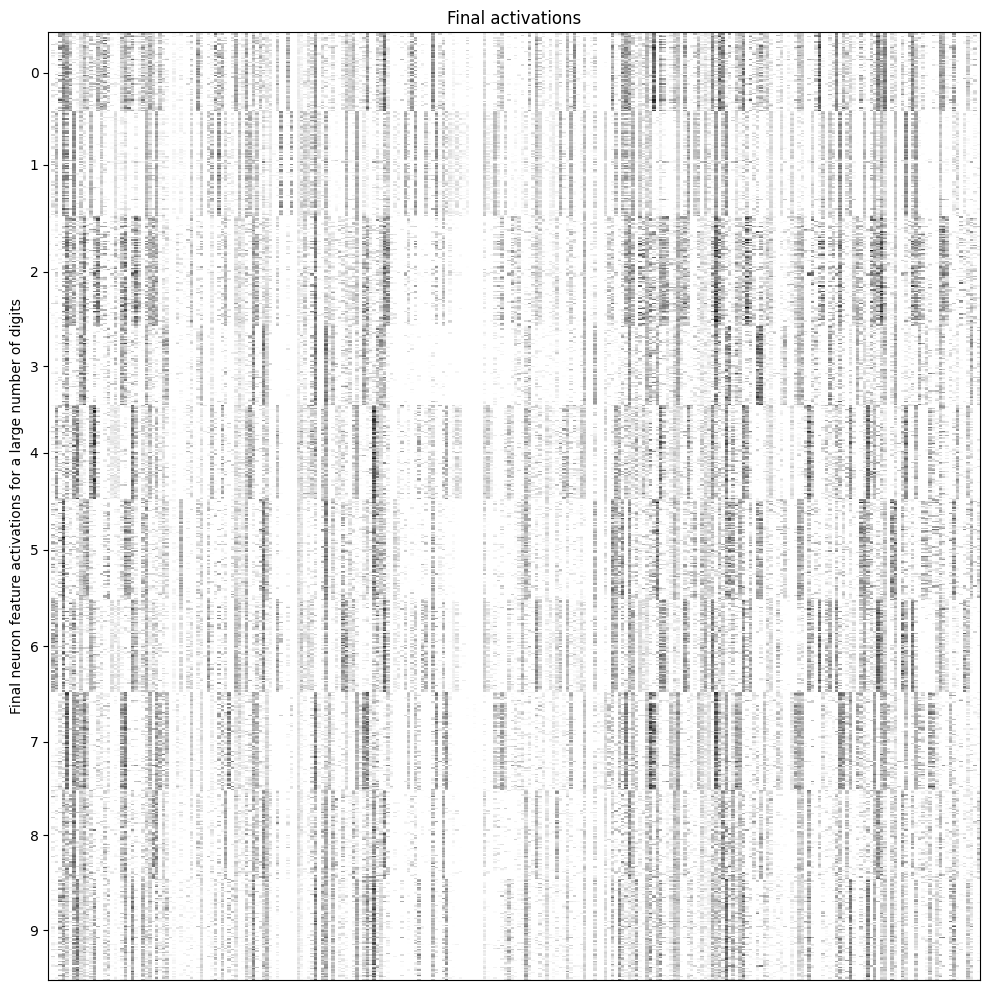

In [ ]:
#@title Code
!pip install torchfunc --quiet

import torchvision
import torchfunc
from matplotlib import cm

cmap = cm.get_cmap('gray_r')

recorder = torchfunc.hooks.recorders.ForwardPre()
recorder.modules(networkCNN)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
  networkCNN(example_data[0:9])

fig = plt.figure(figsize=(13.1, 1))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
for j in range(9):
  for i in range(1):
    plt.subplot(1,10,j+1)
    plt.imshow(example_data[j][0], cmap=cmap, interpolation='none')
    plt.xticks([])
    plt.yticks([])
ax.set_ylabel("Input digits")
ax.set_title("Digits examples")
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
for j in range(10):
  for i in range(9):
    plt.subplot(10,9,j*9 + i+1)
    plt.imshow((recorder.data[2][0])[i][j], cmap=cmap, interpolation='none')
    plt.xticks([])
    plt.yticks([])
ax.set_ylabel("Filtered Digits")
ax.set_title("Layer 1 activations")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
for j in range(10):
  for i in range(9):
    plt.subplot(10,9,j*9 + i+1)
    plt.imshow((recorder.data[3][0])[i][j], cmap=cmap, interpolation='none')
    plt.xticks([])
    plt.yticks([])
ax.set_ylabel("Filtered Digits")
ax.set_title("Layer 2 activations")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
for j in range(10):
  for i in range(9):
    plt.subplot(10,9,j*9 + i+1)
    plt.imshow((recorder.data[4][0])[i][j], cmap=cmap, interpolation='none')
    plt.xticks([])
    plt.yticks([])
ax.set_ylabel("Filtered Digits")
ax.set_title("Layer 3 activations")
plt.tight_layout()
plt.show()

recorder = torchfunc.hooks.recorders.ForwardPre()
recorder.modules(networkCNN)

with torch.no_grad():
  batch, (ex_data_full, ex_target_full) = next(examples)
  for _ in range(10):
    batch, (ex_data, ex_target) = next(examples)
    ex_data_full = torch.cat((ex_data_full, ex_data), axis=0)
    ex_target_full = torch.cat((ex_target_full, ex_target), axis=0)

  ex_target_full_idx = np.argsort(ex_target_full)
  ex_data_full = ex_data_full[ex_target_full_idx]
  networkCNN(ex_data_full)

CNN_output_embedding = recorder.data[5][0]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.imshow(recorder.data[5][0], cmap=cmap, interpolation='none', aspect='auto')

embedding_ticks = []
cumulative_ticks = 0
for num in range(10):
  tick_length = np.sum(num == ex_target_full.detach().numpy())#/len(ex_target_full_idx)
  cumulative_ticks += tick_length
  embedding_ticks.append(cumulative_ticks - tick_length/2)

plt.xticks([])
plt.yticks(embedding_ticks, [i for i in range(10)])

ax.set_title("Final activations")
ax.set_ylabel("Final neuron feature activations for a large number of digits")
plt.tight_layout()
plt.show()


As we can see, after just one layer the images quickly start to loose their original geometry, instead representing abstractions of shapes found in layer 1. Looking at the filter activations for the different numbers for the first layers, we can see that the filters in many cases correspond to different types of edge dectection. Some filters identify vertical edges, some horizontal, some angled edges. It is these features which are then combined hierachically on the later layers to enable the network do identify the different numbers.

The final image shows what the final layer of filter activations looks like for a larget number of numbers, after being flattened into a 1-dimensional array and grouped together. We can see that it is pretty easy to destinguish the different groups of digits from each other, which is what the final layers of the neural network learns to do. But just how easy? Lets do some data analysis to see how the CNN simplifies the task of the nerual network to identify images. First we can plot a correlation matrix of the sorted examples to see how well each digit correlates to each other:

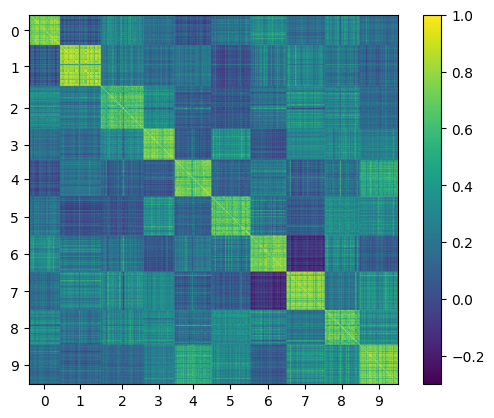

In [ ]:
#@title Code
correlation = np.corrcoef(CNN_output_embedding)
plt.imshow(correlation)
plt.xticks(embedding_ticks, [i for i in range(10)])
plt.yticks(embedding_ticks, [i for i in range(10)])
plt.colorbar()


Here we see that there is a high degree of auto-correlation within each group of numbers. We can also see that some numbers on average are more similar to other numbers, and some less similar. For example, looking at 6 and 7 we can see that they are not very similar to each other, while 2 and 3 are comparatively similar to each other. For the correlation of the embedding dimension we can also see that the number 2 seems that have the largest degree of variability in terms of how it is written. What does the correlation look like when not using CNNs for embedding?

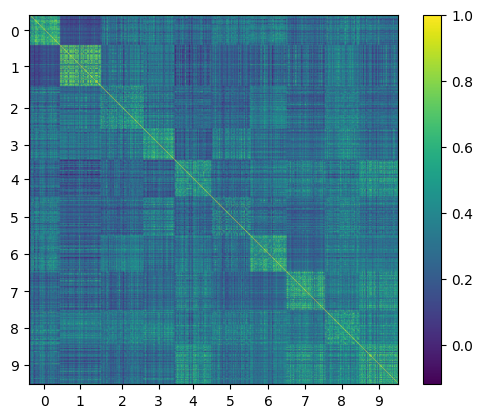

In [ ]:
#@title Code
correlation = np.corrcoef(ex_data_full.reshape(ex_data_full.detach().numpy().shape[0], ex_data_full.detach().numpy().shape[-2] * ex_data_full.detach().numpy().shape[-1]))
plt.imshow(correlation)
plt.xticks(embedding_ticks, [i for i in range(10)])
plt.yticks(embedding_ticks, [i for i in range(10)])
plt.colorbar()


Here we see the benefit of using CNN for feature extraction: The identified features are more easy to separate for different digits than the raw pixel values which are shown here. Another way to visualize this is to use PCA to plot the data set and the embedded features:

Text(0.5, 0.98, 'PCA transformation on raw pixel and embeddings')

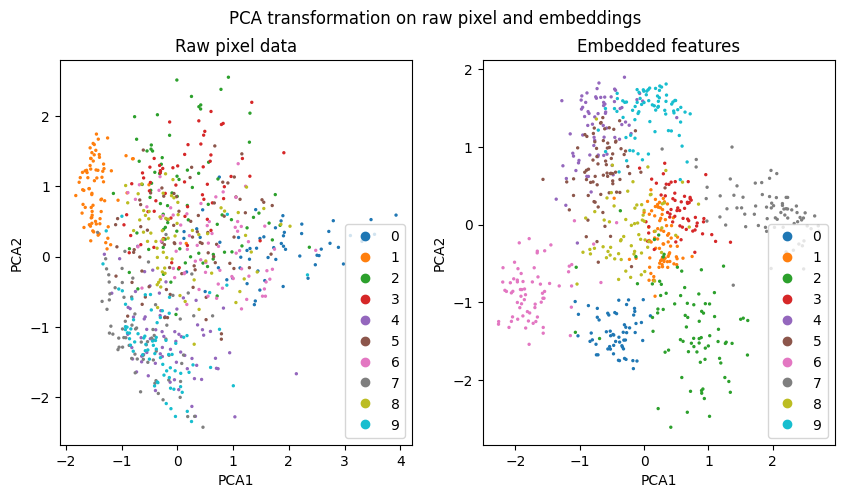

In [ ]:
#@title Code
from sklearn.decomposition import PCA

pca_raw_ = PCA(n_components=2, whiten=True)
pca_raw = pca_raw_.fit_transform(ex_data_full.reshape(ex_data_full.detach().numpy().shape[0], ex_data_full.detach().numpy().shape[-2] * ex_data_full.detach().numpy().shape[-1]))
pca_embedding = PCA(n_components=2, whiten=True).fit_transform(CNN_output_embedding)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))

pca_scatter_raw = ax[0].scatter(pca_raw[:, 0], pca_raw[:, 1], s=2, c=ex_target_full.flatten()[ex_target_full_idx], cmap='tab10')
pca_scatter_emb = ax[1].scatter(pca_embedding[:, 0], pca_embedding[:, 1], s=2, c=ex_target_full.flatten()[ex_target_full_idx], cmap='tab10')

ax[0].set_title('Raw pixel data')
ax[1].set_title('Embedded features')

ax[0].set_xlabel("PCA1")
ax[0].set_ylabel("PCA2")

ax[1].set_xlabel("PCA1")
ax[1].set_ylabel("PCA2")

ax[0].legend(*pca_scatter_raw.legend_elements())
ax[1].legend(*pca_scatter_emb.legend_elements())

plt.suptitle("PCA transformation on raw pixel and embeddings")


Here, the different numbers are colored to show how the numbers are represented by the principal components. As we can see, the CNN embedding are more easily separate even when only using two principal components.

Now that we have reduced out data set to two different principal components for both the raw data there is a nice trick we can do. Since the images are represented using two components, we can use the inverse of these components to see how the digits would look for our synthetic data points.

None


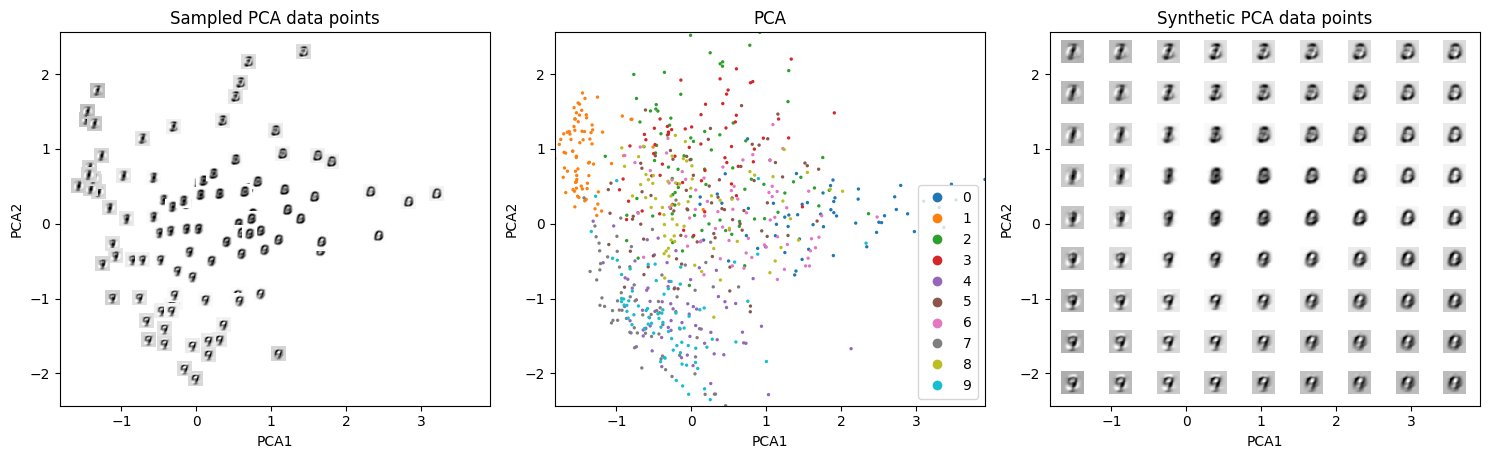

In [ ]:
#@title Code

im_size = 0.2
n_images = 100

sampled_points = pca_raw[np.random.choice(len(pca_raw), n_images, replace=False)]

raw_inverse = pca_raw_.inverse_transform(sampled_points)

fig, ax = plt.subplots(ncols=3, figsize=(15,5))

for i in range(3):
  ax[i].set_xlim(np.min(pca_raw[:, 0]), np.max(pca_raw[:, 0]))
  ax[i].set_ylim(np.min(pca_raw[:, 1]), np.max(pca_raw[:, 1]))

for ind, im in enumerate(raw_inverse):
  image = im.reshape(28, 28)
  ax[0].imshow(image, interpolation='none', cmap=cmap, extent=(sampled_points[ind, 0], sampled_points[ind, 0] + im_size, sampled_points[ind, 1], sampled_points[ind, 1] + im_size,))

pca_scatter_raw = ax[1].scatter(pca_raw[:, 0], pca_raw[:, 1], s=2, c=ex_target_full.flatten()[ex_target_full_idx], cmap='tab10')
ax[1].legend(*pca_scatter_raw.legend_elements())

print(ax[1].set_aspect(1))

pca1_range = np.linspace(np.min(pca_raw[:, 0]), np.max(pca_raw[:, 0]), 10)
pca2_range = np.linspace(np.min(pca_raw[:, 1]), np.max(pca_raw[:, 1]), 10)

grid = []

for a in pca1_range:
  for b in pca2_range:
    grid.append([a, b])

grid = np.vstack(grid)

raw_inverse = pca_raw_.inverse_transform(grid)

im_size = 0.3

for ind, im in enumerate(raw_inverse):
  image = im.reshape(28, 28)
  ax[2].imshow(image, interpolation='none', cmap=cmap, extent=(grid[ind, 0] + im_size/2, grid[ind, 0] + im_size + im_size/2, grid[ind, 1] + im_size/2, grid[ind, 1] + im_size + im_size/2,))

for i in range(3):
  ax[i].set_xlabel("PCA1")
  ax[i].set_ylabel("PCA2")

ax[0].set_title('Sampled PCA data points')
ax[1].set_title('PCA')
ax[2].set_title('Synthetic PCA data points')

plt.tight_layout()
plt.show()


As PCA is a linear methods of dimensionality reduction the reconstruction is both simple and very lossy. While some numbers are reconstructed pretty well, for example the number 9, 1 and 0, others are more difficult to reconstruct.

What if we leave the area of linear methods for dimensionality reduction and venture into the area of non-linear methods? One commonly used method is called Uniform Manifold Approximation and Projection, or UMAP. This method constructs a topographic representation of the data in it's native dimension, in our case 784 dimensions, and tries to reconstruct the same graph in a lower dimension, minimizing the information loss in the transition between the higher dimension representation and the lower dimension representationl.

Text(0.5, 0.98, 'PCA transformation on raw pixel data compared to UMAP')

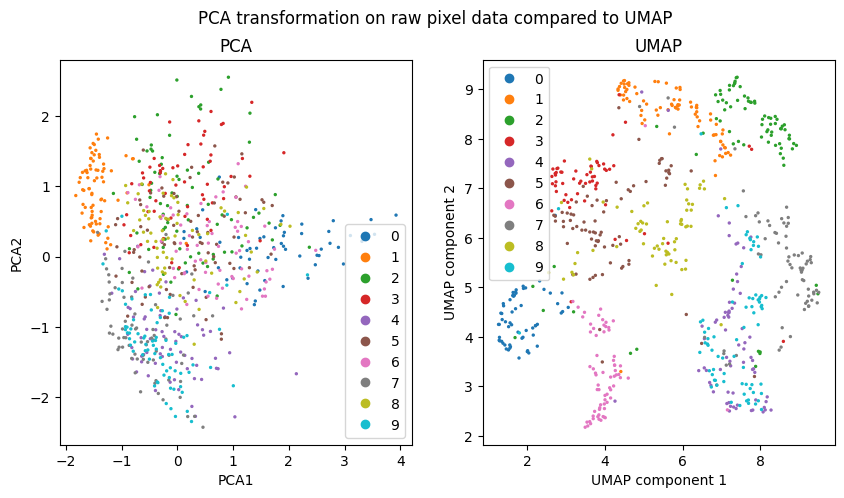

In [ ]:
#@title Code
from umap import UMAP

umap_raw = UMAP(n_components=2)

umap_raw.fit(ex_data_full.reshape(ex_data_full.detach().numpy().shape[0], ex_data_full.detach().numpy().shape[-2] * ex_data_full.detach().numpy().shape[-1]))
umap_data = umap_raw.transform(ex_data_full.reshape(ex_data_full.detach().numpy().shape[0], ex_data_full.detach().numpy().shape[-2] * ex_data_full.detach().numpy().shape[-1]))

fig, ax = plt.subplots(ncols=2, figsize=(10,5))

pca_scatter_raw = ax[0].scatter(pca_raw[:, 0], pca_raw[:, 1], s=2, c=ex_target_full.flatten()[ex_target_full_idx], cmap='tab10')
umap_scatter_emb = ax[1].scatter(umap_data[:, 0], umap_data[:, 1], s=2, c=ex_target_full.flatten()[ex_target_full_idx], cmap='tab10')

ax[0].set_title('PCA')
ax[1].set_title('UMAP')

ax[0].set_xlabel("PCA1")
ax[0].set_ylabel("PCA2")

ax[1].set_xlabel("UMAP component 1")
ax[1].set_ylabel("UMAP component 2")

ax[0].legend(*pca_scatter_raw.legend_elements())
ax[1].legend(*umap_scatter_emb.legend_elements())

plt.suptitle("PCA transformation on raw pixel data compared to UMAP")



Here we see the benefit of applying non-linear feature reduction to the data: the hand written numbers are relatively well-grouped into its corresponding classes, even when reduced to two dimensions. There are some important difference when comparing UMAP to PCA, however. While PCA is solved iteratively for each dimension using linear algebra, UMAP uses a gradient descent approach where each compenent of the lower dimensionalo representation are adjusted iteratively. This has the effect that the UMAP representation has a certain amount of randomness, running the same algorithm on the same data using diffierent initializations will results in different results. UMAP also has more hyperparameters than PCA which must be tuned for optimal performance.

So, UMAP performs pretty well in 2 dimensions on the raw pixel data, where we saw a large grouping of similar digits, especially compared to using PCA. But what happens if we perform the same dimensionality reduction on the features extracted using the CNN architecture?

Text(0.5, 0.98, 'Feature reduction applied to features extracted from the dataset')

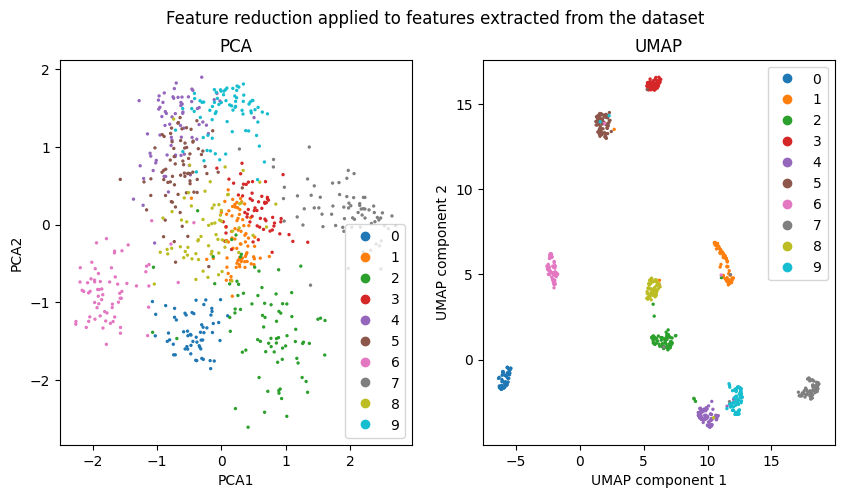

In [ ]:
#@title Code
umap_raw = UMAP(n_components=2)

umap_data = umap_raw.fit_transform(CNN_output_embedding)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))

pca_scatter_emb = ax[0].scatter(pca_embedding[:, 0], pca_embedding[:, 1], s=2, c=ex_target_full.flatten()[ex_target_full_idx], cmap='tab10')
umap_scatter_emb = ax[1].scatter(umap_data[:, 0], umap_data[:, 1], s=2, c=ex_target_full.flatten()[ex_target_full_idx], cmap='tab10')

ax[0].set_title('PCA')
ax[1].set_title('UMAP')

ax[0].set_xlabel("PCA1")
ax[0].set_ylabel("PCA2")

ax[1].set_xlabel("UMAP component 1")
ax[1].set_ylabel("UMAP component 2")

ax[0].legend(*pca_scatter_emb.legend_elements())
ax[1].legend(*umap_scatter_emb.legend_elements())

plt.suptitle("Feature reduction applied to features extracted from the dataset")

As we can see here, the use of UMAP on the extracted features shows us a better representation on how well the network architecture is at actually extracting freatures from the dataset. Compared to PCA, where the features can only be represented in the lower dimensional space using linear, othagonal axes, UMAP allows us to view the extracted features using a non-linear mapping of the data. This is, in fact, what a neural network itself actually does at each layer of the fully connected network, transforming the input data non-linearly to try to minimize the cost function.
